# Association rule mining with electronic health records: Exploring comorbidity diagnoses of major depressive disorder 



Dominic Nicolas Iseli<br>
DSV - Department of Computer and Systems Sciences<br>
Stockholm University<br>
Stockholm, Sweden<br>
dois2136@student.su.se

## Import necessary modules

In [1]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
plt.style.use('science')
plt.rcParams["figure.figsize"] = (10,7)

## Admissions dataset

Read admissions dataset from csv. The dataset includes information about a patient’s admission to the hospital. 

In [2]:
admissions = pd.read_csv('admissions.csv')
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,14679932,21038362,2139-09-26 14:16:00,2139-09-28 11:30:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,SINGLE,UNKNOWN,NaN,NaN,0
1,15585972,24941086,2123-10-07 23:56:00,2123-10-12 11:22:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,WHITE,NaN,NaN,0
2,11989120,21965160,2147-01-14 09:00:00,2147-01-17 14:25:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,UNKNOWN,NaN,NaN,0
3,17817079,24709883,2165-12-27 17:33:00,2165-12-31 21:18:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,OTHER,NaN,NaN,0
4,15078341,23272159,2122-08-28 08:48:00,2122-08-30 12:32:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,0


Analyse general properties and null values of the admissions dataset

In [3]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523740 entries, 0 to 523739
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            523740 non-null  int64 
 1   hadm_id               523740 non-null  int64 
 2   admittime             523740 non-null  object
 3   dischtime             523740 non-null  object
 4   deathtime             9337 non-null    object
 5   admission_type        523740 non-null  object
 6   admission_location    463305 non-null  object
 7   discharge_location    397083 non-null  object
 8   insurance             523740 non-null  object
 9   language              523740 non-null  object
 10  marital_status        457633 non-null  object
 11  ethnicity             523740 non-null  object
 12  edregtime             311504 non-null  object
 13  edouttime             311504 non-null  object
 14  hospital_expire_flag  523740 non-null  int64 
dtypes: int64(3), obje

Transform admittime column to include only year and store in dictionary together with hadm_id, used for calculating the age of the patients later.

In [4]:
admissions['admittime'] =  pd.to_datetime(admissions['admittime'])
admissions['admittime'] = admissions['admittime'].dt.year
admittime_dict = dict(zip(admissions.hadm_id, admissions.admittime.astype(int)))
marital_status_dict = dict(zip(admissions.hadm_id, admissions.marital_status.astype(str)))
ethnicity_dict = dict(zip(admissions.hadm_id, admissions.ethnicity.astype(str)))

## Patient dataset

Read patients dataset from csv-file

In [5]:
patients = pd.read_csv('patients.csv')
patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000048,F,23,2126,2008 - 2010,NaN
1,10002723,F,0,2128,2017 - 2019,NaN
2,10003939,M,0,2184,2008 - 2010,NaN
3,10004222,M,0,2161,2014 - 2016,NaN
4,10005325,F,0,2154,2011 - 2013,NaN


Analyse general properties and null values of the patient dataset

In [6]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382278 entries, 0 to 382277
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   subject_id         382278 non-null  int64 
 1   gender             382278 non-null  object
 2   anchor_age         382278 non-null  int64 
 3   anchor_year        382278 non-null  int64 
 4   anchor_year_group  382278 non-null  object
 5   dod                9509 non-null    object
dtypes: int64(3), object(3)
memory usage: 17.5+ MB


Create gender, anchor_age and anchor_year dictionaries used for mapping later.

In [7]:
gender_dict = dict(zip(patients.subject_id, patients.gender))
anchor_age_dict = dict(zip(patients.subject_id, patients.anchor_age.astype(int)))
anchor_year_dict = dict(zip(patients.subject_id, patients.anchor_year.astype(int)))

Check the unique number of patients

In [8]:
patients['subject_id'].value_counts().sum()

382278

## Diagnoses code dataset

Read dimension table for diagnoses_icd which provides a description/long title of ICD-9/ICD-10 diagnoses.

In [9]:
diagnoses_codes = pd.read_excel('d_icd_diagnoses.xlsx')
diagnoses_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109775 entries, 0 to 109774
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   icd_code     109775 non-null  object
 1   icd_version  109775 non-null  int64 
 2   long_title   109775 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.5+ MB


Include only ICD-10 codes

In [10]:
diagnoses_codes = diagnoses_codes[diagnoses_codes['icd_version'] == 10]
diagnoses_codes.shape

(95109, 3)

Check for duplicates in ICD-code column

In [11]:
duplicates = diagnoses_codes.loc[diagnoses_codes.duplicated(subset=['icd_code'])]
duplicates

,icd_code,icd_version,long_title


Delete icd_version column, as it is not needed anymore

In [12]:
del diagnoses_codes['icd_version']
diagnoses_codes.head()

,icd_code,long_title
9795,B5741,Meningitis in Chagas' disease
9857,B810,Anisakiasis
10057,B811,Intestinal capillariasis
10981,A5489,Other gonococcal infections
11338,B010,Varicella meningitis


Transform ICD diagnoses codes to dictionary to be used for mapping later

In [13]:
diagnoses_codes.set_index('icd_code', inplace=True)
diagnoses_codes = diagnoses_codes.to_dict()
diagnoses_codes = {str(k):str(v) for k,v in diagnoses_codes['long_title'].items()}

## Diagnoses dataset

Read the diagnoses dataset which includes all billed ICD diagnoses for hospitalizations.

In [14]:
diagnoses = pd.read_csv('diagnoses.csv')

Analyse general properties and null values of the diagnoses dataset

In [15]:
diagnoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5280351 entries, 0 to 5280350
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  int64 
dtypes: int64(4), object(1)
memory usage: 201.4+ MB


Include only diagnoses with ICD-10 codes

In [16]:
diagnoses = diagnoses[diagnoses['icd_version'] == 10]

In [17]:
diagnoses.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
2670103,18335503,21596415,2,E861,10
2670104,18335503,21596415,5,O99512,10
2670105,18335503,21596415,6,J45909,10
2670106,18335503,21596415,1,O99612,10
2670107,18335503,21596415,7,O99282,10


Add a long title of the diagnoses to the diagnoses dataset

In [18]:
diagnoses['long_title'] = diagnoses.icd_code.map(diagnoses_codes)

Check how many individual patients there are in the diagnoses dataset, as one patient can have several diagnoses.

In [19]:
len(diagnoses['subject_id'].value_counts())

107704

Count number of diagnoses by ICD-10 code

In [20]:
icd_count = diagnoses['icd_code'].value_counts()
icd_count = pd.DataFrame(icd_count)
icd_count['code'] = icd_count.index
icd_count['long_title'] = icd_count.code.map(diagnoses_codes)
icd_count.to_excel(r'output\icd_count.xlsx')

Check how many individual hadm_id's there are in the dataset, which represent a single patient’s admission to the hospital. One patient can have several admissions to the hospital.


In [21]:
len(diagnoses['hadm_id'].value_counts())

185743

Check for missing values in the diagnoses dataset

In [22]:
diagnoses.isna().sum()

subject_id     0
hadm_id        0
seq_num        0
icd_code       0
icd_version    0
long_title     0
dtype: int64

Calculate the age of each patient for each diagnosis. Include the ethnicity for each diagnosis. Create a new column as a combination of the icd_code and icd_code_long_title, which will help in interpretation of results.

In [23]:
diagnoses['admittime'] = diagnoses.hadm_id.map(admittime_dict)
diagnoses['anchor_age'] = diagnoses.subject_id.map(anchor_age_dict)
diagnoses['anchor_year'] = diagnoses.subject_id.map(anchor_year_dict)
diagnoses['birth_year'] = diagnoses['anchor_year'] - diagnoses['anchor_age']
diagnoses['age'] = diagnoses['admittime'] - diagnoses['birth_year']
diagnoses['ethnicity'] = diagnoses.hadm_id.map(ethnicity_dict)
diagnoses['icd_code_long_title'] = diagnoses['icd_code'].astype(str) + ": " + diagnoses['long_title']
del diagnoses['admittime']
del diagnoses['anchor_age']
del diagnoses['anchor_year']
del diagnoses['birth_year']
diagnoses

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,age,ethnicity,icd_code_long_title
2670103,18335503,21596415,2,E861,10,Hypovolemia,33.0,WHITE,E861: Hypovolemia
2670104,18335503,21596415,5,O99512,10,Diseases of the respiratory system complicatin...,33.0,WHITE,O99512: Diseases of the respiratory system com...
2670105,18335503,21596415,6,J45909,10,"Unspecified asthma, uncomplicated",33.0,WHITE,"J45909: Unspecified asthma, uncomplicated"
2670106,18335503,21596415,1,O99612,10,Diseases of the digestive system complicating ...,33.0,WHITE,O99612: Diseases of the digestive system compl...
2670107,18335503,21596415,7,O99282,10,"Endocrine, nutritional and metabolic diseases ...",33.0,WHITE,"O99282: Endocrine, nutritional and metabolic d..."
...,...,...,...,...,...,...,...,...,...
5280346,13747041,25594844,6,R531,10,Weakness,45.0,WHITE,R531: Weakness
5280347,13747041,25594844,8,R0902,10,Hypoxemia,45.0,WHITE,R0902: Hypoxemia
5280348,13747041,25594844,4,F1120,10,"Opioid dependence, uncomplicated",45.0,WHITE,"F1120: Opioid dependence, uncomplicated"
5280349,13747041,25594844,2,J189,10,"Pneumonia, unspecified organism",45.0,WHITE,"J189: Pneumonia, unspecified organism"


Calculate the average age of a patient among all hospital stays (hadm_id's) and create dictionary for mapping later.

In [24]:
avg_age = diagnoses.groupby(['subject_id', 'hadm_id'], as_index=False).mean().groupby('subject_id')['age'].mean().astype(int)
avg_age_dict = avg_age.to_dict()

Store the ethnicity of each patient in dictionary.

In [25]:
ethnicity = diagnoses.groupby(['subject_id'], as_index=False).first()
ethnicity_dict_new = pd.Series(ethnicity.ethnicity.values,index=ethnicity.subject_id).to_dict()

## ICD-codes to be analyzed/of interest

Define which ICD-codes are of interest and store in list.

In [26]:
codes = pd.read_excel('codes.xlsx', header=None, dtype=str)
#codes = list(codes[0])
codes = ['F329']
codes

['F329']

Create a new dataset from the diagnoses dataset only containing the ICD-codes of intereset as defined above.

In [27]:
depression_diagnoses = diagnoses.copy
depression_diagnoses = diagnoses[diagnoses['icd_code'].isin(codes)]

Check shape of the dataset with the diagnoses of interest.

In [28]:
depression_diagnoses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30398 entries, 2935125 to 5280321
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   subject_id           30398 non-null  int64  
 1   hadm_id              30398 non-null  int64  
 2   seq_num              30398 non-null  int64  
 3   icd_code             30398 non-null  object 
 4   icd_version          30398 non-null  int64  
 5   long_title           30398 non-null  object 
 6   age                  30398 non-null  float64
 7   ethnicity            30398 non-null  object 
 8   icd_code_long_title  30398 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 2.3+ MB


Create bins for seq_num (priority of diagnosis)

In [29]:
depression_diagnoses = depression_diagnoses.copy()
depression_diagnoses['seq_num_group'] = pd.cut(x=depression_diagnoses['seq_num'], bins=[0,5,9,14,19,29,100], labels = ['1-5', '6-9', '10-14', '15-19', '20-29', '30-39'])
depression_diagnoses

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,age,ethnicity,icd_code_long_title,seq_num_group
2935125,15548420,27667659,3,F329,10,"Major depressive disorder, single episode, uns...",38.0,WHITE,"F329: Major depressive disorder, single episod...",1-5
2952402,18817907,28875074,9,F329,10,"Major depressive disorder, single episode, uns...",30.0,WHITE,"F329: Major depressive disorder, single episod...",6-9
2972814,15066286,23086326,10,F329,10,"Major depressive disorder, single episode, uns...",39.0,OTHER,"F329: Major depressive disorder, single episod...",10-14
2982523,16213188,26834904,3,F329,10,"Major depressive disorder, single episode, uns...",31.0,BLACK/AFRICAN AMERICAN,"F329: Major depressive disorder, single episod...",1-5
2984731,11625936,22823980,18,F329,10,"Major depressive disorder, single episode, uns...",84.0,WHITE,"F329: Major depressive disorder, single episod...",15-19
...,...,...,...,...,...,...,...,...,...,...
5280188,14408787,23504839,6,F329,10,"Major depressive disorder, single episode, uns...",57.0,WHITE,"F329: Major depressive disorder, single episod...",6-9
5280205,10604045,26683973,7,F329,10,"Major depressive disorder, single episode, uns...",70.0,WHITE,"F329: Major depressive disorder, single episod...",6-9
5280306,19665140,28016573,11,F329,10,"Major depressive disorder, single episode, uns...",49.0,WHITE,"F329: Major depressive disorder, single episod...",10-14
5280311,12023609,25944107,9,F329,10,"Major depressive disorder, single episode, uns...",62.0,WHITE,"F329: Major depressive disorder, single episod...",6-9


Create pie chart for seq_num groups.

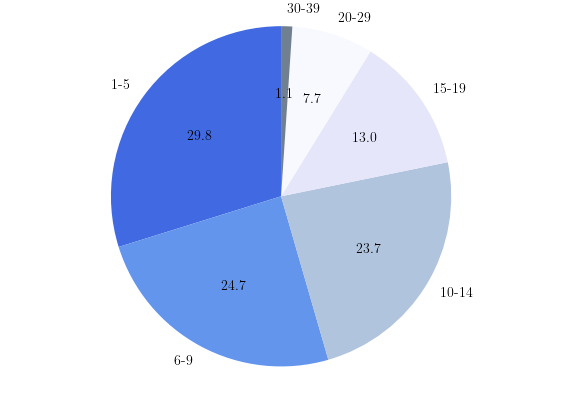

In [30]:
labels = ['1-5', '6-9', '10-14', '15-19', '20-29', '30-39']
sizes = depression_diagnoses['seq_num_group'].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14}, colors = ['royalblue', 'cornflowerblue','lightsteelblue','lavender', 'ghostwhite', 'slategrey'])
ax1.axis('equal')

plt.show()

Store list of all patients with depression.

In [31]:
depr_patients_allseq = depression_diagnoses['subject_id'].unique().tolist()

Only inlcude patients that have depression as a primary diagnoses. We only consider prioritites of 1, 2, 3, 4, 5 assigned to the diagnosis.

In [32]:
seq_num = [1,2,3,4,5]
depression_diagnoses = depression_diagnoses[depression_diagnoses['seq_num'].isin(seq_num)]
depression_diagnoses

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,age,ethnicity,icd_code_long_title,seq_num_group
2935125,15548420,27667659,3,F329,10,"Major depressive disorder, single episode, uns...",38.0,WHITE,"F329: Major depressive disorder, single episod...",1-5
2982523,16213188,26834904,3,F329,10,"Major depressive disorder, single episode, uns...",31.0,BLACK/AFRICAN AMERICAN,"F329: Major depressive disorder, single episod...",1-5
3016887,17710225,28227252,2,F329,10,"Major depressive disorder, single episode, uns...",57.0,WHITE,"F329: Major depressive disorder, single episod...",1-5
3025484,17754388,25783452,2,F329,10,"Major depressive disorder, single episode, uns...",38.0,OTHER,"F329: Major depressive disorder, single episod...",1-5
3026053,12501777,20519230,5,F329,10,"Major depressive disorder, single episode, uns...",65.0,WHITE,"F329: Major depressive disorder, single episod...",1-5
...,...,...,...,...,...,...,...,...,...,...
5279668,16825095,26628718,3,F329,10,"Major depressive disorder, single episode, uns...",21.0,OTHER,"F329: Major depressive disorder, single episod...",1-5
5279677,13192739,27479647,1,F329,10,"Major depressive disorder, single episode, uns...",54.0,HISPANIC/LATINO,"F329: Major depressive disorder, single episod...",1-5
5279778,10264646,20347132,3,F329,10,"Major depressive disorder, single episode, uns...",48.0,WHITE,"F329: Major depressive disorder, single episod...",1-5
5280063,11012896,24213599,3,F329,10,"Major depressive disorder, single episode, uns...",22.0,WHITE,"F329: Major depressive disorder, single episod...",1-5


Plot chart with distribution of depression diagnoses.

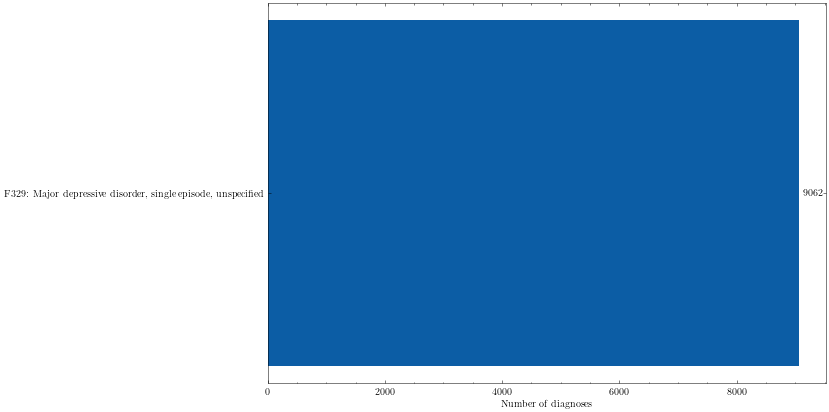

In [33]:
x = depression_diagnoses['icd_code_long_title'].value_counts().index
y = depression_diagnoses['icd_code_long_title'].value_counts()
y_pos = np.arange(len(y))

fig, ax = plt.subplots()
hbars = ax.barh(y_pos, y, align='center')
ax.set_yticks(y_pos, labels=x)
ax.invert_yaxis()
ax.set_xlabel('Number of diagnoses')
ax.bar_label(hbars, label_type='edge', padding=4)
plt.show()

Check how many individual patients there are in the depression_diagnoses dataset. One patient can have several depression diagnoses.

In [34]:
len(depression_diagnoses['subject_id'].value_counts())

6659

Get unique subject_id's and hadm_id's from depression diagnoses dataset. This will get a list of all patients that have the diagnoses and a list of all the admissions where the disease was diagnosed.

In [35]:
depr_patients = depression_diagnoses['subject_id'].unique().tolist()
depr_patients_hadm_id = depression_diagnoses['hadm_id'].unique().tolist()

Add demographic information to dataset with depression patients by creating a separate dataframe. Create age groups based on age column. Calculate descpritive statistics of depression patients.

In [36]:
depr_patients_df = pd.DataFrame(depr_patients, columns=['subject_id'])
depr_patients_df['gender'] = depr_patients_df.subject_id.map(gender_dict)
depr_patients_df['age'] = depr_patients_df.subject_id.map(avg_age_dict)
depr_patients_df['age_group'] = pd.cut(x=depr_patients_df['age'], bins=[17,30,39,49,59,69,79,120], labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '>80'])
depr_patients_df_describe = depr_patients_df.groupby(["age_group"]).describe()
cols = [0,1,2,3,4,5,6,7]
depr_patients_df_describe.drop(depr_patients_df_describe.columns[cols],axis=1,inplace=True)
depr_patients_df_describe.to_excel(r'output\age_experimental_group.xlsx')
depr_patients_df_describe

age                                                   
            count       mean       std   min   25%   50%   75%   max
age_group                                                           
18-29      1918.0  23.232534  3.522955  18.0  20.0  23.0  26.0  30.0
30-39      1041.0  34.926993  2.579962  31.0  33.0  35.0  37.0  39.0
40-49       884.0  44.699095  2.918671  40.0  42.0  45.0  47.0  49.0
50-59      1212.0  54.429043  2.845730  50.0  52.0  54.0  57.0  59.0
60-69       922.0  63.903471  2.805766  60.0  61.0  64.0  66.0  69.0
70-79       457.0  73.542670  2.745578  70.0  71.0  73.0  76.0  79.0
>80         225.0  86.408889  4.172819  80.0  83.0  86.0  90.0  98.0

Create pie chart for age groups.

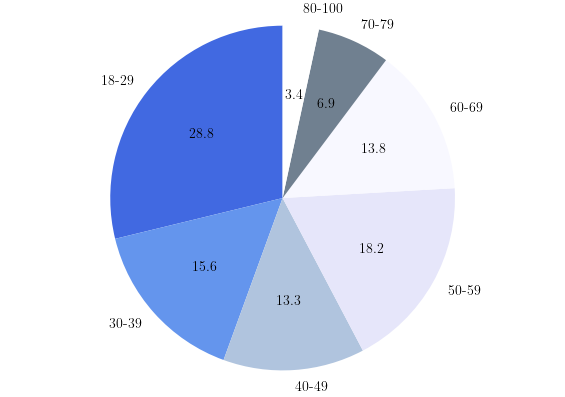

In [37]:
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-100']
sizes = depr_patients_df_describe[('age', 'count')]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14}, colors = ['royalblue', 'cornflowerblue','lightsteelblue','lavender', 'ghostwhite', 'slategrey', 'white'])
ax1.axis('equal')

plt.show()

Create demographics table for ethnicity.

In [38]:
depr_patients_df['ethnicity'] = depr_patients_df.subject_id.map(ethnicity_dict_new)
depr_patients_df_ethnicity_describe = depr_patients_df.groupby(["ethnicity"]).describe()
cols = [0,1,2,3,4,5,6,7]
depr_patients_df_ethnicity_describe.drop(depr_patients_df_ethnicity_describe.columns[cols],axis=1,inplace=True)
depr_patients_df_ethnicity_describe.to_excel(r'output\ethnicity_experimental_group.xlsx')
depr_patients_df_ethnicity_describe

age                                     \
                                count       mean        std   min    25%   
ethnicity                                                                  
AMERICAN INDIAN/ALASKA NATIVE    14.0  43.785714  20.494572  20.0  32.25   
ASIAN                           245.0  30.395918  15.920216  18.0  20.00   
BLACK/AFRICAN AMERICAN          871.0  42.026406  16.579880  18.0  27.00   
HISPANIC/LATINO                 395.0  44.797468  15.425751  18.0  33.00   
OTHER                           391.0  38.122762  17.401894  18.0  23.00   
UNKNOWN                         147.0  45.244898  17.734956  18.0  28.50   
WHITE                          4596.0  46.661010  18.759458  18.0  30.00   

                                                 
                                50%   75%   max  
ethnicity                                        
AMERICAN INDIAN/ALASKA NATIVE  38.5  46.0  90.0  
ASIAN                          23.0  33.0  90.0  
BLACK/AFRICAN AMERICAN         40.0  54.0  93.0  
HISPANIC/LATINO                45.0  57.0  94.0  
OTHER                          34.0  50.0  91.0  
UNKNOWN                        48.0  57.0  91.0  
WHITE                          47.0  61.0  98.0

Create pie chart for ethnicities.

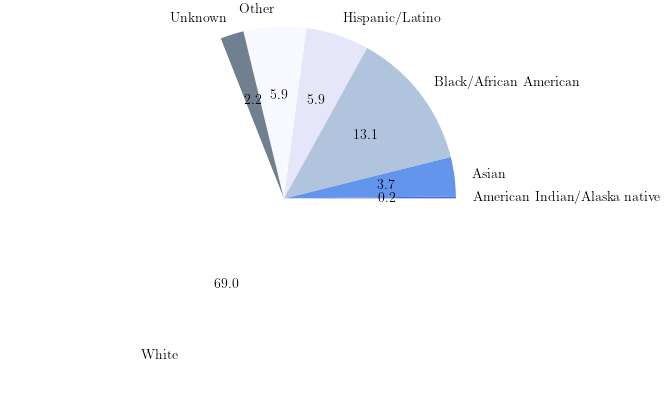

In [39]:
labels = ['American Indian/Alaska native', 'Asian', 'Black/African American', 'Hispanic/Latino', 'Other', 'Unknown', 'White']
sizes = depr_patients_df_ethnicity_describe[('age', 'count')]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=360, textprops={'fontsize': 14}, colors = ['royalblue', 'cornflowerblue','lightsteelblue','lavender', 'ghostwhite', 'slategrey', 'white'])
ax1.axis('equal')

plt.show()

Create demographic info table of all patients with depression.

In [40]:
depr_patients_df.describe()

,subject_id,age
count,6.659000e+03,6659.000000
mean,1.503336e+07,44.807178
std,2.882505e+06,18.473685
min,1.000222e+07,18.000000
25%,1.252698e+07,28.000000
50%,1.503568e+07,44.000000
75%,1.752126e+07,59.000000
max,1.999947e+07,98.000000


Create pie chart of gender share.

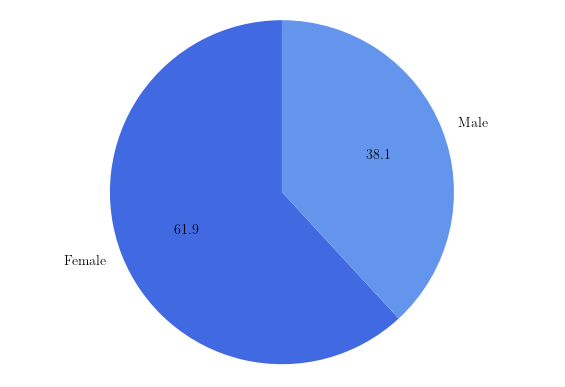

In [41]:
labels = 'Female', 'Male'
sizes = depr_patients_df['gender'].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14}, colors = ['royalblue', 'cornflowerblue'])
ax1.axis('equal')

plt.show()

Create age info table of all patients with depression, splitted by male/female and ethnicity.

In [42]:
depr_patients_df.groupby(["gender", "age_group"]).count()

subject_id   age  ethnicity
gender age_group                             
F      18-29            1185  1185       1185
       30-39             632   632        632
       40-49             548   548        548
       50-59             713   713        713
       60-69             556   556        556
       70-79             313   313        313
       >80               173   173        173
M      18-29             733   733        733
       30-39             409   409        409
       40-49             336   336        336
       50-59             499   499        499
       60-69             366   366        366
       70-79             144   144        144
       >80                52    52         52

In [43]:
depr_patients_df.groupby(["gender", "ethnicity"]).count()

subject_id   age  age_group
gender ethnicity                                                 
F      AMERICAN INDIAN/ALASKA NATIVE          12    12         12
       ASIAN                                 162   162        162
       BLACK/AFRICAN AMERICAN                554   554        554
       HISPANIC/LATINO                       248   248        248
       OTHER                                 237   237        237
       UNKNOWN                                84    84         84
       WHITE                                2823  2823       2823
M      AMERICAN INDIAN/ALASKA NATIVE           2     2          2
       ASIAN                                  83    83         83
       BLACK/AFRICAN AMERICAN                317   317        317
       HISPANIC/LATINO                       147   147        147
       OTHER                                 154   154        154
       UNKNOWN                                63    63         63
       WHITE                                1773  1773       1773

Patients can have other diagnoses than depression. In the next step, we get all other diagnoses for the depression patients from the diagnoses dataset.

In [44]:
diagnoses_depr_patients = diagnoses[diagnoses['subject_id'].isin(depr_patients)]
diagnoses_depr_patients

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,age,ethnicity,icd_code_long_title
2901044,11443746,27515077,16,G43109,10,"Migraine with aura, not intractable, without s...",52.0,WHITE,"G43109: Migraine with aura, not intractable, w..."
2901045,11443746,27515077,18,G4700,10,"Insomnia, unspecified",52.0,WHITE,"G4700: Insomnia, unspecified"
2901046,11443746,27515077,14,E669,10,"Obesity, unspecified",52.0,WHITE,"E669: Obesity, unspecified"
2901047,11443746,27515077,20,M549,10,"Dorsalgia, unspecified",52.0,WHITE,"M549: Dorsalgia, unspecified"
2901048,11443746,27515077,9,I10,10,Essential (primary) hypertension,52.0,WHITE,I10: Essential (primary) hypertension
...,...,...,...,...,...,...,...,...,...
5280323,12225682,29240982,3,F14929,10,"Cocaine use, unspecified with intoxication, un...",27.0,BLACK/AFRICAN AMERICAN,"F14929: Cocaine use, unspecified with intoxica..."
5280324,12225682,29240982,4,F15929,10,"Other stimulant use, unspecified with intoxica...",27.0,BLACK/AFRICAN AMERICAN,"F15929: Other stimulant use, unspecified with ..."
5280325,12225682,29240982,1,F419,10,"Anxiety disorder, unspecified",27.0,BLACK/AFRICAN AMERICAN,"F419: Anxiety disorder, unspecified"
5280326,12225682,29240982,6,Z915,10,Personal history of self-harm,27.0,BLACK/AFRICAN AMERICAN,Z915: Personal history of self-harm


Only include the admissions where the patients have been diagnosed with depression. We only want to study the admissions where the diagnoses of interest was diagnosed.

In [45]:
diagnoses_depr_patients = diagnoses_depr_patients[diagnoses_depr_patients['hadm_id'].isin(depr_patients_hadm_id)]
diagnoses_depr_patients

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,age,ethnicity,icd_code_long_title
2935120,15548420,27667659,2,Z370,10,Single live birth,38.0,WHITE,Z370: Single live birth
2935121,15548420,27667659,6,O701,10,Second degree perineal laceration during delivery,38.0,WHITE,O701: Second degree perineal laceration during...
2935122,15548420,27667659,5,O770,10,Labor and delivery complicated by meconium in ...,38.0,WHITE,O770: Labor and delivery complicated by meconi...
2935123,15548420,27667659,1,O99344,10,Other mental disorders complicating childbirth,38.0,WHITE,O99344: Other mental disorders complicating ch...
2935124,15548420,27667659,4,Z3A39,10,39 weeks gestation of pregnancy,38.0,WHITE,Z3A39: 39 weeks gestation of pregnancy
...,...,...,...,...,...,...,...,...,...
5280323,12225682,29240982,3,F14929,10,"Cocaine use, unspecified with intoxication, un...",27.0,BLACK/AFRICAN AMERICAN,"F14929: Cocaine use, unspecified with intoxica..."
5280324,12225682,29240982,4,F15929,10,"Other stimulant use, unspecified with intoxica...",27.0,BLACK/AFRICAN AMERICAN,"F15929: Other stimulant use, unspecified with ..."
5280325,12225682,29240982,1,F419,10,"Anxiety disorder, unspecified",27.0,BLACK/AFRICAN AMERICAN,"F419: Anxiety disorder, unspecified"
5280326,12225682,29240982,6,Z915,10,Personal history of self-harm,27.0,BLACK/AFRICAN AMERICAN,Z915: Personal history of self-harm


Create dictionary of ICD-10 letter groups.

In [46]:
icd_groups = pd.read_excel('icd_groups.xlsx',header=None)
icd_groups_dict = dict(zip(icd_groups[0], icd_groups[1]))

Create a new dataframe only with comorbid diagnoses. Map with ICD-group to get an idea of most common type of diagnosis of the comorbidities.

In [47]:
not_diagnoses_depr_patients = diagnoses_depr_patients[~diagnoses_depr_patients.icd_code.isin(codes)]
not_diagnoses_depr_patients = not_diagnoses_depr_patients.copy()
not_diagnoses_depr_patients['icd_group'] = not_diagnoses_depr_patients['icd_code'].astype(str).str[0]
not_diagnoses_depr_patients['icd_groups'] = not_diagnoses_depr_patients.icd_group.map(icd_groups_dict)
len(not_diagnoses_depr_patients)

61556

In [48]:
not_diagnoses_depr_patients['icd_code'].value_counts()

F419       3605
R45851     2227
I10        1848
F17210     1561
K219       1328
           ... 
E320          1
T463X5A       1
T383X2A       1
O99321        1
S22061A       1
Name: icd_code, Length: 4514, dtype: int64

Create chart for comorbidity diagnoses overview.

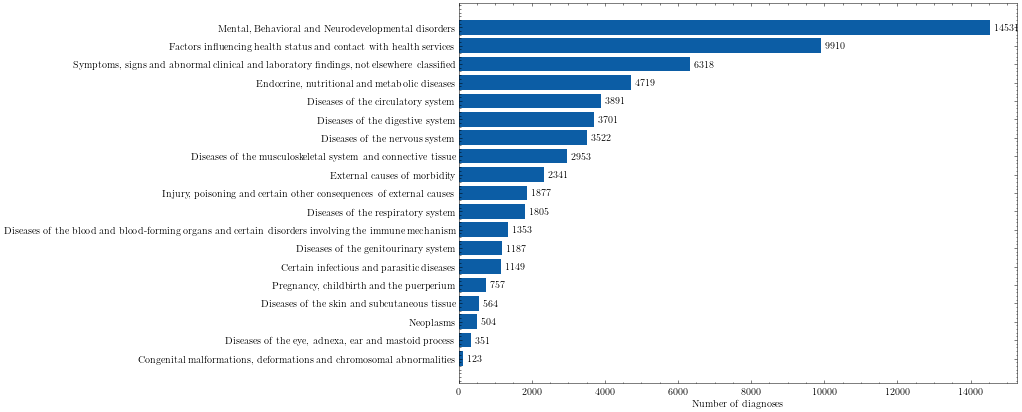

In [49]:
x = not_diagnoses_depr_patients['icd_groups'].value_counts().index
y = not_diagnoses_depr_patients['icd_groups'].value_counts()
y_pos = np.arange(len(y))

fig, ax = plt.subplots()
hbars = ax.barh(y_pos, y, align='center')
ax.set_yticks(y_pos, labels=x)
ax.invert_yaxis()
ax.set_xlabel('Number of diagnoses')
#ax.set_title('Number of diagnoses')
ax.bar_label(hbars, label_type='edge', padding=4)
plt.show()

Create table with all patients and their diagnoses.

In [50]:
diagnoses_depr_patients = diagnoses_depr_patients.copy()
diagnoses_depr_patients["idx"] = diagnoses_depr_patients.groupby("subject_id").cumcount()+1
output = diagnoses_depr_patients.pivot("subject_id", "idx", "icd_code_long_title")
output["count"] = output.count(axis=1)
output.sort_values(by=['count'], ascending=False, inplace=True)
output

idx,1,2,3,4,5,6,7,8,9,10,...,286,287,288,289,290,291,292,293,294,count
subject_id,,,,,,,,,,,,,,,,,,,,,
14394983,R45851: Suicidal ideations,Z21: Asymptomatic human immunodeficiency virus...,K861: Other chronic pancreatitis,"F10129: Alcohol abuse with intoxication, unspe...",R531: Weakness,I69398: Other sequelae of cerebral infarction,"F329: Major depressive disorder, single episod...",I252: Old myocardial infarction,F602: Antisocial personality disorder,M79651: Pain in right thigh,...,"F329: Major depressive disorder, single episod...",R45851: Suicidal ideations,B1920: Unspecified viral hepatitis C without h...,R419: Unspecified symptoms and signs involving...,Z9114: Patient's other noncompliance with medi...,"F10129: Alcohol abuse with intoxication, unspe...","F1490: Cocaine use, unspecified, uncomplicated",F602: Antisocial personality disorder,"F209: Schizophrenia, unspecified",294
13763648,"F419: Anxiety disorder, unspecified","R030: Elevated blood-pressure reading, without...","F17200: Nicotine dependence, unspecified, unco...","F329: Major depressive disorder, single episod...","J45909: Unspecified asthma, uncomplicated","F1290: Cannabis use, unspecified, uncomplicated",Z23: Encounter for immunization,"F1010: Alcohol abuse, uncomplicated","F1910: Other psychoactive substance abuse, unc...",R072: Precordial pain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211
16675371,"R739: Hyperglycemia, unspecified",Z590: Homelessness,I10: Essential (primary) hypertension,"F10129: Alcohol abuse with intoxication, unspe...","F329: Major depressive disorder, single episod...",E780: Pure hypercholesterolemia,Y929: Unspecified place or not applicable,Y042XXA: Assault by strike against or bumped i...,E119: Type 2 diabetes mellitus without complic...,"F10129: Alcohol abuse with intoxication, unspe...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208
10264646,"F329: Major depressive disorder, single episod...",Z590: Homelessness,"F1120: Opioid dependence, uncomplicated",Z9114: Patient's other noncompliance with medi...,R45851: Suicidal ideations,"F10129: Alcohol abuse with intoxication, unspe...",Z818: Family history of other mental and behav...,"F10129: Alcohol abuse with intoxication, unspe...","F17210: Nicotine dependence, cigarettes, uncom...","F1910: Other psychoactive substance abuse, unc...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189
13813803,Z9884: Bariatric surgery status,"K760: Fatty (change of) liver, not elsewhere c...",E282: Polycystic ovarian syndrome,"D649: Anemia, unspecified",R109: Unspecified abdominal pain,Z931: Gastrostomy status,"F419: Anxiety disorder, unspecified",Z23: Encounter for immunization,F39: Unspecified mood [affective] disorder,"F329: Major depressive disorder, single episod...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13384679,"F329: Major depressive disorder, single episod...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
10372063,"F329: Major depressive disorder, single episod...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
10223853,"F329: Major depressive disorder, single episod...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


## Transaction encoding and association rule mining

The apriori function expects data in a one-hot encoded pandas DataFrame. Therefore we encode transactions with creating a crosstab from subject_id and icd_code_long_title with the help of pandas.

In [51]:
crosstab = pd.crosstab(diagnoses_depr_patients['subject_id'], diagnoses_depr_patients['icd_code_long_title'])
crosstab

icd_code_long_title,A020: Salmonella enteritis,A038: Other shigellosis,"A0471: Enterocolitis due to Clostridium difficile, recurrent","A0472: Enterocolitis due to Clostridium difficile, not specified as recurrent",A047: Enterocolitis due to Clostridium difficile,A048: Other specified bacterial intestinal infections,A071: Giardiasis [lambliasis],A0811: Acute gastroenteropathy due to Norwalk agent,A0839: Other viral enteritis,"A084: Viral intestinal infection, unspecified",...,"Z9849: Cataract extraction status, unspecified eye",Z9851: Tubal ligation status,Z9861: Coronary angioplasty status,Z9862: Peripheral vascular angioplasty status,Z9884: Bariatric surgery status,Z98890: Other specified postprocedural states,Z9889: Other specified postprocedural states,Z992: Dependence on renal dialysis,Z993: Dependence on wheelchair,Z9981: Dependence on supplemental oxygen
subject_id,,,,,,,,,,,,,,,,,,,,,
10002221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10002315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10002528,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10002618,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10006630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19993501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19996832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19997887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Check how many diagnoses a patient has and group them.

In [52]:
num_diagnoses = pd.DataFrame(crosstab[crosstab > 0].count(axis=1).sort_values(ascending=False), columns=['num_diagnoses'])
num_diagnoses['group'] = pd.cut(x=num_diagnoses['num_diagnoses'], bins=[0,1,2,3,4,5,9,19,29,49,1000], labels = ['1', '2', '3', '4', '5','6-9','10-19', '20-29', '30-49', '>=50'])
num_diagnoses_describe = num_diagnoses.groupby("group").describe()
num_diagnoses_describe.to_excel(r'output\num_diagnoses_experimental_group.xlsx')
num_diagnoses_describe

num_diagnoses                                                    
              count       mean       std   min   25%   50%    75%   max
group                                                                  
1              48.0   1.000000  0.000000   1.0   1.0   1.0   1.00   1.0
2             236.0   2.000000  0.000000   2.0   2.0   2.0   2.00   2.0
3             371.0   3.000000  0.000000   3.0   3.0   3.0   3.00   3.0
4             509.0   4.000000  0.000000   4.0   4.0   4.0   4.00   4.0
5             689.0   5.000000  0.000000   5.0   5.0   5.0   5.00   5.0
6-9          2398.0   7.359883  1.114328   6.0   6.0   7.0   8.00   9.0
10-19        2066.0  12.807357  2.560203  10.0  11.0  12.0  14.00  19.0
20-29         257.0  22.906615  2.745564  20.0  20.0  22.0  24.00  29.0
30-49          79.0  36.113924  5.337308  30.0  31.5  35.0  39.00  48.0
>=50            6.0  57.500000  4.324350  51.0  55.0  58.5  59.75  63.0

Get info on number and distribution of comorbidities.

In [53]:
num_diagnoses['without depression'] = num_diagnoses['num_diagnoses'] - 1
num_diagnoses.describe()

,num_diagnoses,without depression
count,6659.000000,6659.000000
mean,9.056615,8.056615
std,5.887317,5.887317
min,1.000000,0.000000
25%,5.000000,4.000000
50%,8.000000,7.000000
75%,11.000000,10.000000
max,63.000000,62.000000


Binarize the transaction encoded dataset.

In [54]:
crosstab = crosstab.astype(bool)
crosstab

icd_code_long_title,A020: Salmonella enteritis,A038: Other shigellosis,"A0471: Enterocolitis due to Clostridium difficile, recurrent","A0472: Enterocolitis due to Clostridium difficile, not specified as recurrent",A047: Enterocolitis due to Clostridium difficile,A048: Other specified bacterial intestinal infections,A071: Giardiasis [lambliasis],A0811: Acute gastroenteropathy due to Norwalk agent,A0839: Other viral enteritis,"A084: Viral intestinal infection, unspecified",...,"Z9849: Cataract extraction status, unspecified eye",Z9851: Tubal ligation status,Z9861: Coronary angioplasty status,Z9862: Peripheral vascular angioplasty status,Z9884: Bariatric surgery status,Z98890: Other specified postprocedural states,Z9889: Other specified postprocedural states,Z992: Dependence on renal dialysis,Z993: Dependence on wheelchair,Z9981: Dependence on supplemental oxygen
subject_id,,,,,,,,,,,,,,,,,,,,,
10002221,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10002315,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10002528,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10002618,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10006630,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19993501,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19996832,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19997887,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Generate frequent itemsets with mlxtend

In [55]:
frequent_itemsets = apriori(crosstab, min_support=0.06, use_colnames=True)
frequent_itemsets.sort_values(by=['support'], ascending=False).reset_index(drop=True)
frequent_itemsets_export = frequent_itemsets.copy()
frequent_itemsets_export['itemsets'] = frequent_itemsets_export['itemsets'].apply(lambda x: '; '.join(list(x))).astype("unicode")
frequent_itemsets_export['itemsets'] = '{'+ frequent_itemsets_export['itemsets']
frequent_itemsets_export['itemsets'] = frequent_itemsets_export['itemsets'] + '}'

Save frequent itemsets to Excel file.

In [56]:
frequent_itemsets_export.to_excel(r'output\frequent_itemsets_experimental_group.xlsx')

Generate association rules with mlxtend

In [57]:
assoc_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
assoc_rules.sort_values(by=['support'], ascending=False).reset_index(drop=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(F419: Anxiety disorder, unspecified)","(F329: Major depressive disorder, single episo...",0.439105,1.000000,0.439105,1.000000,1.000000,0.000000,inf
1,(R45851: Suicidal ideations),"(F329: Major depressive disorder, single episo...",0.247184,1.000000,0.247184,1.000000,1.000000,0.000000,inf
2,(I10: Essential (primary) hypertension),"(F329: Major depressive disorder, single episo...",0.223607,1.000000,0.223607,1.000000,1.000000,0.000000,inf
3,"(F17210: Nicotine dependence, cigarettes, unco...","(F329: Major depressive disorder, single episo...",0.181409,1.000000,0.181409,1.000000,1.000000,0.000000,inf
4,(K219: Gastro-esophageal reflux disease withou...,"(F329: Major depressive disorder, single episo...",0.166542,1.000000,0.166542,1.000000,1.000000,0.000000,inf
5,"(E785: Hyperlipidemia, unspecified)","(F329: Major depressive disorder, single episo...",0.143415,1.000000,0.143415,1.000000,1.000000,0.000000,inf
6,(Z87891: Personal history of nicotine dependence),"(F329: Major depressive disorder, single episo...",0.134405,1.000000,0.134405,1.000000,1.000000,0.000000,inf
7,"(F4310: Post-traumatic stress disorder, unspec...","(F329: Major depressive disorder, single episo...",0.132753,1.000000,0.132753,1.000000,1.000000,0.000000,inf
8,"(R45851: Suicidal ideations, F419: Anxiety dis...","(F329: Major depressive disorder, single episo...",0.118486,1.000000,0.118486,1.000000,1.000000,0.000000,inf
9,"(J45909: Unspecified asthma, uncomplicated)","(F329: Major depressive disorder, single episo...",0.107073,1.000000,0.107073,1.000000,1.000000,0.000000,inf


Reformat association rules with {} brackets.

In [58]:
assoc_rules['antecedents'] = assoc_rules['antecedents'].apply(lambda x: '; '.join(list(x))).astype("unicode")
assoc_rules['consequents'] = assoc_rules['consequents'].apply(lambda x: '; '.join(list(x))).astype("unicode")
assoc_rules['antecedents'] = '{' + assoc_rules['antecedents']
assoc_rules['antecedents'] = assoc_rules['antecedents'] + '}'
assoc_rules['consequents'] = '{' + assoc_rules['consequents']
assoc_rules['consequents'] = assoc_rules['consequents'] + '}'
assoc_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"{E039: Hypothyroidism, unspecified}","{F329: Major depressive disorder, single episo...",0.078690,1.000000,0.078690,1.000000,1.000000,0.000000,inf
1,"{E669: Obesity, unspecified}","{F329: Major depressive disorder, single episo...",0.072083,1.000000,0.072083,1.000000,1.000000,0.000000,inf
2,"{E785: Hyperlipidemia, unspecified}","{F329: Major depressive disorder, single episo...",0.143415,1.000000,0.143415,1.000000,1.000000,0.000000,inf
3,"{F10129: Alcohol abuse with intoxication, unsp...","{F329: Major depressive disorder, single episo...",0.060670,1.000000,0.060670,1.000000,1.000000,0.000000,inf
4,"{F1290: Cannabis use, unspecified, uncomplicated}","{F329: Major depressive disorder, single episo...",0.060219,1.000000,0.060219,1.000000,1.000000,0.000000,inf
5,"{F17210: Nicotine dependence, cigarettes, unco...","{F329: Major depressive disorder, single episo...",0.181409,1.000000,0.181409,1.000000,1.000000,0.000000,inf
6,"{F419: Anxiety disorder, unspecified}","{F329: Major depressive disorder, single episo...",0.439105,1.000000,0.439105,1.000000,1.000000,0.000000,inf
7,"{F4310: Post-traumatic stress disorder, unspec...","{F329: Major depressive disorder, single episo...",0.132753,1.000000,0.132753,1.000000,1.000000,0.000000,inf
8,"{G4700: Insomnia, unspecified}","{F329: Major depressive disorder, single episo...",0.062171,1.000000,0.062171,1.000000,1.000000,0.000000,inf
9,{G8929: Other chronic pain},"{F329: Major depressive disorder, single episo...",0.068479,1.000000,0.068479,1.000000,1.000000,0.000000,inf


Export association rules to Excel file

In [59]:
assoc_rules.to_excel(r'output\association_rules_experimental_group.xlsx')

## Statistical analysis/Chi-squared test with control group

Randomly select control group of equal size as depression patients, with equal male/female and age group characteristics. Firstly, make sure that all control group patients have a diagnosis, because there are patients in the dataset that have no diagnoses.

In [60]:
patients_with_diagnoses = diagnoses['subject_id'].drop_duplicates().to_list()

In [61]:
patients = patients.copy()
patients = patients[patients.subject_id.isin(patients_with_diagnoses)]
not_depr_patients = patients[~patients.subject_id.isin(depr_patients_allseq)]
not_depr_patients = not_depr_patients.copy()
not_depr_patients['avg_age'] = not_depr_patients.subject_id.map(avg_age_dict)
not_depr_patients['age_group'] = pd.cut(x=not_depr_patients['avg_age'], bins=[-1,17,30,39,49,59,69,79,120], labels = ['0-17','18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '>80'])

female = not_depr_patients[not_depr_patients.gender == 'F']
male = not_depr_patients[not_depr_patients.gender == 'M']

female18_29 = female.loc[female.age_group == '18-29', 'subject_id'].sample(n=1185, random_state=22).to_list()
female30_39 = female.loc[female.age_group == '30-39', 'subject_id'].sample(n=632, random_state=22).to_list()
female40_49 = female.loc[female.age_group == '40-49', 'subject_id'].sample(n=548, random_state=22).to_list()
female50_59 = female.loc[female.age_group == '50-59', 'subject_id'].sample(n=713, random_state=22).to_list()
female60_69 = female.loc[female.age_group == '60-69', 'subject_id'].sample(n=556, random_state=22).to_list()
female70_79 = female.loc[female.age_group == '70-79', 'subject_id'].sample(n=313, random_state=22).to_list()
female80 = female.loc[female.age_group == '>80', 'subject_id'].sample(n=173, random_state=22).to_list()


male18_29 = male.loc[male.age_group == '18-29', 'subject_id'].sample(n=733, random_state=22).to_list()
male30_39 = male.loc[male.age_group == '30-39', 'subject_id'].sample(n=409, random_state=22).to_list()
male40_49 = male.loc[male.age_group == '40-49', 'subject_id'].sample(n=336, random_state=22).to_list()
male50_59 = male.loc[male.age_group == '50-59', 'subject_id'].sample(n=499, random_state=22).to_list()
male60_69 = male.loc[male.age_group == '60-69', 'subject_id'].sample(n=366, random_state=22).to_list()
male70_79 = male.loc[male.age_group == '70-79', 'subject_id'].sample(n=144, random_state=22).to_list()
male80 = male.loc[male.age_group == '>80', 'subject_id'].sample(n=52, random_state=22).to_list()

control_grp = female18_29 + female30_39 + female40_49 + female50_59 + female60_69 + female70_79 + female80 + male18_29 + male30_39 + male40_49 + male50_59 + male60_69 + male70_79 + male80
len(control_grp)

6659

Create separate dataframe with control group patients and add demographic information.

In [62]:
control_grp_df = pd.DataFrame(control_grp, columns=['subject_id'])
control_grp_df['gender'] = control_grp_df.subject_id.map(gender_dict)
control_grp_df['age'] = control_grp_df.subject_id.map(avg_age_dict)
control_grp_df
control_grp_df['gender'].value_counts()

F    4120
M    2539
Name: gender, dtype: int64

Create tables with demographic information of control group.

In [63]:
control_grp_df['age_group'] = pd.cut(x=control_grp_df['age'], bins=[17,30,39,49,59,69,79,120], labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '>80'])
control_grp_df_describe = control_grp_df.groupby(["age_group"]).describe()
cols = [0,1,2,3,4,5,6,7]
control_grp_df_describe.drop(control_grp_df_describe.columns[cols],axis=1,inplace=True)
control_grp_df_describe.to_excel(r'output\age_control_group.xlsx')
control_grp_df_describe

age                                                   
            count       mean       std   min   25%   50%   75%   max
age_group                                                           
18-29      1918.0  24.758081  3.593868  18.0  22.0  25.0  28.0  30.0
30-39      1041.0  34.780980  2.564188  31.0  33.0  35.0  37.0  39.0
40-49       884.0  44.673077  2.903218  40.0  42.0  45.0  47.0  49.0
50-59      1212.0  54.962046  2.829340  50.0  53.0  55.0  57.0  59.0
60-69       922.0  64.618221  2.834872  60.0  62.0  65.0  67.0  69.0
70-79       457.0  74.282276  2.800606  70.0  72.0  74.0  77.0  79.0
>80         225.0  86.066667  4.220486  80.0  82.0  86.0  90.0  99.0

In [64]:
control_grp_df.describe()

,subject_id,age
count,6.659000e+03,6659.000000
mean,1.499796e+07,45.455474
std,2.895805e+06,18.191951
min,1.000254e+07,18.000000
25%,1.250417e+07,29.000000
50%,1.494686e+07,44.000000
75%,1.746927e+07,59.000000
max,1.999946e+07,99.000000


In [65]:
control_grp_df['ethnicity'] = control_grp_df.subject_id.map(ethnicity_dict_new)
control_grp_df.isna().sum()
control_grp_df_ethnicity_describe = control_grp_df.groupby(["ethnicity"]).describe()
cols = [0,1,2,3,4,5,6,7]
control_grp_df_ethnicity_describe.drop(control_grp_df_ethnicity_describe.columns[cols],axis=1,inplace=True)
control_grp_df_ethnicity_describe.to_excel(r'output\ethnicity_control_group.xlsx')
control_grp_df_ethnicity_describe

age                                          \
                                count       mean        std   min   25%   50%   
ethnicity                                                                       
AMERICAN INDIAN/ALASKA NATIVE    21.0  41.142857  13.353972  25.0  30.0  41.0   
ASIAN                           365.0  40.342466  17.946516  18.0  25.0  35.0   
BLACK/AFRICAN AMERICAN         1141.0  43.193690  16.536514  18.0  29.0  41.0   
HISPANIC/LATINO                 413.0  40.975787  15.493481  18.0  29.0  38.0   
OTHER                           515.0  40.366990  16.783332  18.0  26.0  36.0   
UNKNOWN                         384.0  44.414062  18.789556  18.0  28.0  40.5   
WHITE                          3820.0  47.918325  18.668863  18.0  31.0  48.0   

                                           
                                75%   max  
ethnicity                                  
AMERICAN INDIAN/ALASKA NATIVE  46.0  81.0  
ASIAN                          54.0  91.0  
BLACK/AFRICAN AMERICAN         56.0  92.0  
HISPANIC/LATINO                53.0  83.0  
OTHER                          53.0  91.0  
UNKNOWN                        59.0  91.0  
WHITE                          62.0  99.0

Include all diagnoses of control group patients.

In [66]:
control_grp_diagnoses = diagnoses[diagnoses['subject_id'].isin(control_grp)]

Create a new column as a combination of the icd_code and icd_code_long_title, which will help in interpretation of results.

In [67]:
control_grp_diagnoses = control_grp_diagnoses.copy()
control_grp_diagnoses['icd_code_long_title'] = control_grp_diagnoses['icd_code'].astype(str) + ": " + control_grp_diagnoses['long_title']
control_grp_diagnoses

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,age,ethnicity,icd_code_long_title
2833697,11810816,27862869,6,Z3A39,10,39 weeks gestation of pregnancy,42.0,UNKNOWN,Z3A39: 39 weeks gestation of pregnancy
2833698,11810816,27862869,1,O321XX0,10,"Maternal care for breech presentation, not app...",42.0,UNKNOWN,O321XX0: Maternal care for breech presentation...
2833699,11810816,27862869,8,Z6833,10,"Body mass index (BMI) 33.0-33.9, adult",42.0,UNKNOWN,"Z6833: Body mass index (BMI) 33.0-33.9, adult"
2833700,11810816,27862869,5,O700,10,First degree perineal laceration during delivery,42.0,UNKNOWN,O700: First degree perineal laceration during ...
2833701,11810816,27862869,2,O1092,10,Unspecified pre-existing hypertension complica...,42.0,UNKNOWN,O1092: Unspecified pre-existing hypertension c...
...,...,...,...,...,...,...,...,...,...
5280115,19568216,22381165,5,I252,10,Old myocardial infarction,49.0,OTHER,I252: Old myocardial infarction
5280116,19568216,22381165,3,I2510,10,Atherosclerotic heart disease of native corona...,49.0,OTHER,I2510: Atherosclerotic heart disease of native...
5280117,19568216,22381165,1,R079,10,"Chest pain, unspecified",49.0,OTHER,"R079: Chest pain, unspecified"
5280118,19568216,22381165,8,E7800,10,"Pure hypercholesterolemia, unspecified",49.0,OTHER,"E7800: Pure hypercholesterolemia, unspecified"


Create table with all patients and their diagnoses.

In [68]:
control_grp_diagnoses = control_grp_diagnoses.copy()
control_grp_diagnoses["idx"] = control_grp_diagnoses.groupby("subject_id").cumcount()+1
output = control_grp_diagnoses.pivot("subject_id", "idx", "icd_code_long_title")
output["count"] = output.count(axis=1)
output.sort_values(by=['count'], ascending=False, inplace=True)
output

idx,1,2,3,4,5,6,7,8,9,10,...,388,389,390,391,392,393,394,395,396,count
subject_id,,,,,,,,,,,,,,,,,,,,,
13602608,Y92234: Operating room of hospital as the plac...,Z86711: Personal history of pulmonary embolism,Z794: Long term (current) use of insulin,"F4310: Post-traumatic stress disorder, unspeci...",Z86718: Personal history of other venous throm...,"F17210: Nicotine dependence, cigarettes, uncom...",R740: Nonspecific elevation of levels of trans...,I10: Essential (primary) hypertension,R300: Dysuria,Y658: Other specified misadventures during sur...,...,K219: Gastro-esophageal reflux disease without...,Z89611: Acquired absence of right leg above knee,M25552: Pain in left hip,"G40909: Epilepsy, unspecified, not intractable...","N12: Tubulo-interstitial nephritis, not specif...","A419: Sepsis, unspecified organism","N189: Chronic kidney disease, unspecified",D473: Essential (hemorrhagic) thrombocythemia,"F17200: Nicotine dependence, unspecified, unco...",396
17295976,"J209: Acute bronchitis, unspecified",Z930: Tracheostomy status,"J189: Pneumonia, unspecified organism",E71440: Ruvalcaba-Myhre-Smith syndrome,J9621: Acute and chronic respiratory failure w...,"J9809: Other diseases of bronchus, not elsewhe...",M941: Relapsing polychondritis,K219: Gastro-esophageal reflux disease without...,B9561: Methicillin susceptible Staphylococcus ...,J398: Other specified diseases of upper respir...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,374
10760122,"I712: Thoracic aortic aneurysm, without rupture",Z720: Tobacco use,M791: Myalgia,"F1021: Alcohol dependence, in remission",C220: Liver cell carcinoma,I10: Essential (primary) hypertension,B182: Chronic viral hepatitis C,K7030: Alcoholic cirrhosis of liver without as...,F39: Unspecified mood [affective] disorder,B181: Chronic viral hepatitis B without delta-...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,303
14214341,I10: Essential (primary) hypertension,Z940: Kidney transplant status,L03115: Cellulitis of right lower limb,"E785: Hyperlipidemia, unspecified",Z794: Long term (current) use of insulin,G4733: Obstructive sleep apnea (adult) (pediat...,L97419: Non-pressure chronic ulcer of right he...,Z89021: Acquired absence of right finger(s),E1151: Type 2 diabetes mellitus with diabetic ...,K219: Gastro-esophageal reflux disease without...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,289
17361720,I4892: Unspecified atrial flutter,H409: Unspecified glaucoma,E875: Hyperkalemia,"N179: Acute kidney failure, unspecified","E785: Hyperlipidemia, unspecified",R269: Unspecified abnormalities of gait and mo...,I4891: Unspecified atrial fibrillation,R195: Other fecal abnormalities,Z66: Do not resuscitate,Z853: Personal history of malignant neoplasm o...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17451669,I2699: Other pulmonary embolism without acute ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
12252504,K529: Noninfective gastroenteritis and colitis...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
19568248,"K5190: Ulcerative colitis, unspecified, withou...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


Create crosstab for control group with subject_id and icd_code_long_title. 

In [69]:
control_grp_crosstab = pd.crosstab(control_grp_diagnoses['subject_id'], control_grp_diagnoses['icd_code_long_title'])

Check how many diagnoses a patient in the control group has and group them.

In [70]:
num_diagnoses_control_grp = pd.DataFrame(control_grp_crosstab[control_grp_crosstab > 0].count(axis=1).sort_values(ascending=False), columns=['num_diagnoses'])
num_diagnoses_control_grp['group'] = pd.cut(x=num_diagnoses_control_grp['num_diagnoses'], bins=[0,1,2,3,4,5,9,19,29,49,1000], labels = ['1', '2', '3', '4', '5','6-9','10-19', '20-29', '30-49', '>=50'])
num_diagnoses_control_grp_describe = num_diagnoses_control_grp.groupby("group").describe()
num_diagnoses_control_grp_describe.to_excel(r'output\num_diagnoses_control_group.xlsx')
num_diagnoses_control_grp_describe

num_diagnoses                                                     
              count       mean        std   min   25%   50%   75%    max
group                                                                   
1             205.0   1.000000   0.000000   1.0   1.0   1.0   1.0    1.0
2             347.0   2.000000   0.000000   2.0   2.0   2.0   2.0    2.0
3             429.0   3.000000   0.000000   3.0   3.0   3.0   3.0    3.0
4             521.0   4.000000   0.000000   4.0   4.0   4.0   4.0    4.0
5             525.0   5.000000   0.000000   5.0   5.0   5.0   5.0    5.0
6-9          1680.0   7.380357   1.104960   6.0   6.0   7.0   8.0    9.0
10-19        1808.0  13.441925   2.802669  10.0  11.0  13.0  16.0   19.0
20-29         582.0  23.764605   2.824393  20.0  21.0  23.0  26.0   29.0
30-49         399.0  37.308271   5.295082  30.0  33.0  37.0  41.0   49.0
>=50          163.0  68.006135  19.005359  50.0  54.0  62.0  75.5  168.0

Calculate average number of diagnoses in the control group.

In [71]:
num_diagnoses_control_grp.describe()

,num_diagnoses
count,6659.000000
mean,12.524253
std,13.022226
min,1.000000
25%,5.000000
50%,8.000000
75%,15.000000
max,168.000000


Binarize the dataframe.

In [72]:
control_grp_crosstab = control_grp_crosstab.astype(bool)
control_grp_crosstab

icd_code_long_title,A020: Salmonella enteritis,"A029: Salmonella infection, unspecified","A039: Shigellosis, unspecified",A044: Other intestinal Escherichia coli infections,A045: Campylobacter enteritis,"A0471: Enterocolitis due to Clostridium difficile, recurrent","A0472: Enterocolitis due to Clostridium difficile, not specified as recurrent",A047: Enterocolitis due to Clostridium difficile,A048: Other specified bacterial intestinal infections,"A049: Bacterial intestinal infection, unspecified",...,Z9861: Coronary angioplasty status,Z9862: Peripheral vascular angioplasty status,Z9884: Bariatric surgery status,Z98890: Other specified postprocedural states,Z98891: History of uterine scar from previous surgery,Z9889: Other specified postprocedural states,Z9911: Dependence on respirator [ventilator] status,Z992: Dependence on renal dialysis,Z993: Dependence on wheelchair,Z9981: Dependence on supplemental oxygen
subject_id,,,,,,,,,,,,,,,,,,,,,
10002545,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10003637,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10004322,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10008287,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10010663,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19992992,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
19994717,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19996016,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Create frequent itemsets of control group with mlxtend.

In [73]:
frequent_itemsets_control_grp = apriori(control_grp_crosstab, min_support=0.001, use_colnames=True, low_memory=True)
frequent_itemsets_control_grp.sort_values(by=['support'], ascending=False).reset_index(drop=True)
frequent_itemsets_control_grp.to_excel(r'output\frequent_itemsets_control_grp.xlsx')